In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
from collections import Counter
from Bio.PDB import PDBParser
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,classification_report,confusion_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import json
import time
import torch
from torch import nn, optim
import matplotlib.colors
from torch.utils.data import DataLoader, Dataset
import nglview as nv

In [2]:
%matplotlib inline

In [3]:
for record in SeqIO.parse('alpha_synclein.fasta','fasta'):
    alpha_syn_record = record
    alpha_syn_dna = record.seq
print(alpha_syn_record)
len(alpha_syn_dna)

ID: AF163864.1
Name: AF163864.1
Description: AF163864.1 Homo sapiens SNCA isoform (SNCA) gene, complete cds, alternatively spliced
Number of features: 0
Seq('AATTTTCCTTGAAAAACATAGATGTCCAGTTCTATCTCTCATATTTTTTCTTTT...TAG', SingleLetterAlphabet())


145606

In [4]:
for record in SeqIO.parse('parkin.fasta','fasta'):
    parkin = record
    parkin_dna = record.seq
print(parkin)
len(parkin_dna)

ID: AB009973.1
Name: AB009973.1
Description: AB009973.1 Homo sapiens parkin mRNA for Parkin, complete cds
Number of features: 0
Seq('TCCGGGAGGATTACCCAGGAGACCGCTGGTGGGAGGCGCGGCTGGCGCCGCTGC...AAA', SingleLetterAlphabet())


2960

In [5]:
for record in SeqIO.parse('pink1.fasta','fasta'):
    pink = record
    pink_dna = record.seq
print(pink)
len(pink_dna)

ID: NG_008164.1
Name: NG_008164.1
Description: NG_008164.1 Homo sapiens PTEN induced kinase 1 (PINK1), RefSeqGene on chromosome 1; nuclear gene for mitochondrial product
Number of features: 0
Seq('CACAGGCCATTTGTCACTCATATTTGGCTCAGAATAAACCTCTTCAAATATTTT...TTA', SingleLetterAlphabet())


25057

In [18]:
#function with the decisions for the dot plot
def fillMatrix(M):
    #add window size w
    ct = 0
    M[0][0] = ""
    for r in range(1,M.shape[0]):
        for c in range(1,M.shape[1]):
            if M[r][0] == M[0][c]:
                M[r][c]= '*'
                if r == c:
                    ct += 1
            else:
                M[r][c]= " "
    incorr = M.shape[0] - ct - 1
    print('Number of aligned bases: ', ct)
    print('Number of unaligned bases: ', incorr , '\n')
    
#create and print the dot plot
def fill_print():
    D = np.zeros([len(sequence1)+1,len(sequence2)+1],dtype=str)
    for r in range(0,len(sequence1)):
        D[r+1][0] = sequence1[r:r+1]
    for c in range(0,len(sequence2)):
        D[0][c+1] = sequence2[c:c+1]
    
    fillMatrix(D)
    print(D)

def fill_plot():
    D = np.zeros([len(sequence1)+1,len(sequence2)+1],dtype=str)
    for r in range(0,len(sequence1)):
        D[r+1][0] = sequence1[r:r+1]
    for c in range(0,len(sequence2)):
        D[0][c+1] = sequence2[c:c+1]
    
    fillMatrix(D)
    print(D)
    
    # create a very simple color palette
    colors = [[1,.5,.5], [1,0,0], [0,1,0], [0,0,1], [0,0,0], [0, .5, .5]]
    cm = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm([-3,-2,-1,0,1,2,2], cm.N)
    
    fig,ax = plt.subplots(figsize=(10,10),dpi=70)
    D_red = np.delete(D,0,axis=1)
    D_red = np.delete(D_red,0,axis=0)
    D_red_log = D_red == '*'
    ax.imshow(D_red_log,cmap=cm,norm=norm)

In [22]:
seq1 = alpha_syn_dna[:1000]
seq2 = pink_dna[:1000]

In [23]:
sequence1 = str(seq1)
sequence2 = str(seq2)

fill_print()

Number of aligned bases:  278
Number of unaligned bases:  722 

[['' 'C' 'A' ... 'G' 'A' 'A']
 ['A' ' ' '*' ... ' ' '*' '*']
 ['A' ' ' '*' ... ' ' '*' '*']
 ...
 ['G' ' ' ' ' ... '*' ' ' ' ']
 ['A' ' ' '*' ... ' ' '*' '*']
 ['A' ' ' '*' ... ' ' '*' '*']]


Number of aligned bases:  278
Number of unaligned bases:  722 

[['' 'C' 'A' ... 'G' 'A' 'A']
 ['A' ' ' '*' ... ' ' '*' '*']
 ['A' ' ' '*' ... ' ' '*' '*']
 ...
 ['G' ' ' ' ' ... '*' ' ' ' ']
 ['A' ' ' '*' ... ' ' '*' '*']
 ['A' ' ' '*' ... ' ' '*' '*']]


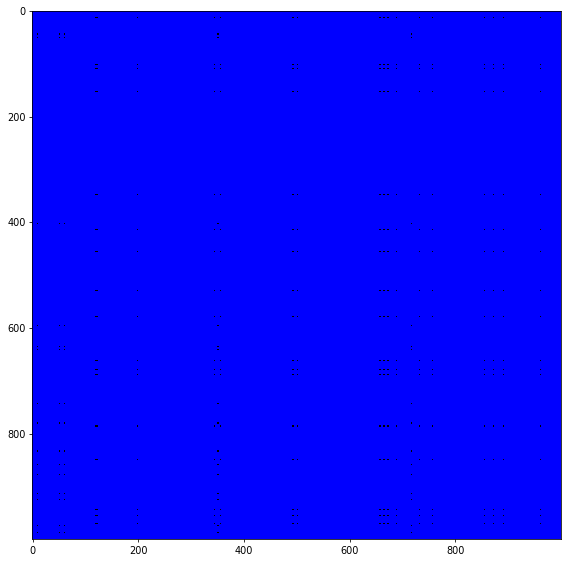

In [24]:
sequence1 = str(seq1)
sequence2 = str(seq2)

fill_plot()

Number of aligned bases:  244
Number of unaligned bases:  756 

[['' 'C' 'A' ... 'G' 'A' 'A']
 ['T' ' ' ' ' ... ' ' ' ' ' ']
 ['C' '*' ' ' ... ' ' ' ' ' ']
 ...
 ['A' ' ' '*' ... ' ' '*' '*']
 ['G' ' ' ' ' ... '*' ' ' ' ']
 ['A' ' ' '*' ... ' ' '*' '*']]
Number of aligned bases:  244
Number of unaligned bases:  756 

[['' 'C' 'A' ... 'G' 'A' 'A']
 ['T' ' ' ' ' ... ' ' ' ' ' ']
 ['C' '*' ' ' ... ' ' ' ' ' ']
 ...
 ['A' ' ' '*' ... ' ' '*' '*']
 ['G' ' ' ' ' ... '*' ' ' ' ']
 ['A' ' ' '*' ... ' ' '*' '*']]


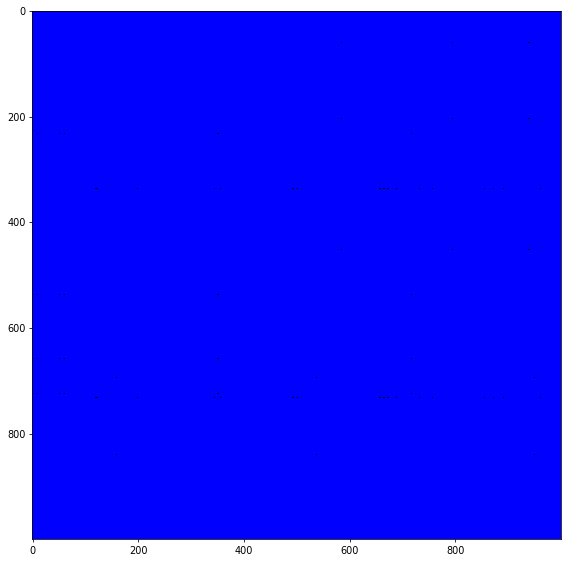

In [26]:
seq1 = parkin_dna[:1000]
seq2 = pink_dna[:1000]

sequence1 = str(seq1)
sequence2 = str(seq2)

fill_print()


fill_plot()

Number of aligned bases:  228
Number of unaligned bases:  772 

[['' 'A' 'A' ... 'G' 'A' 'A']
 ['T' ' ' ' ' ... ' ' ' ' ' ']
 ['C' ' ' ' ' ... ' ' ' ' ' ']
 ...
 ['A' '*' '*' ... ' ' '*' '*']
 ['G' ' ' ' ' ... '*' ' ' ' ']
 ['A' '*' '*' ... ' ' '*' '*']]
Number of aligned bases:  228
Number of unaligned bases:  772 

[['' 'A' 'A' ... 'G' 'A' 'A']
 ['T' ' ' ' ' ... ' ' ' ' ' ']
 ['C' ' ' ' ' ... ' ' ' ' ' ']
 ...
 ['A' '*' '*' ... ' ' '*' '*']
 ['G' ' ' ' ' ... '*' ' ' ' ']
 ['A' '*' '*' ... ' ' '*' '*']]


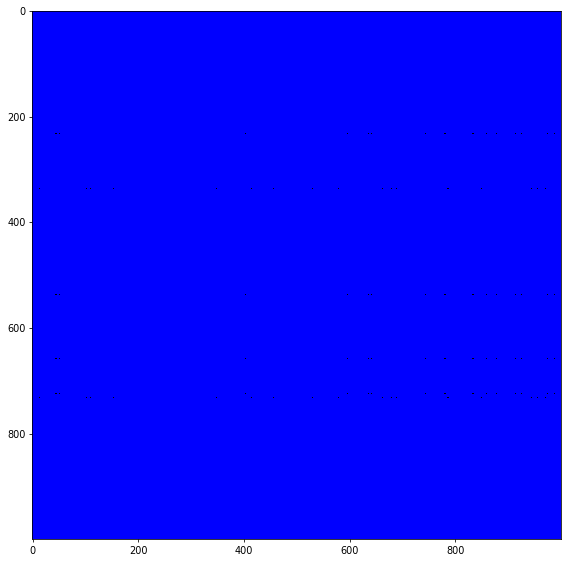

In [27]:
seq1 = parkin_dna[:1000]
seq2 = alpha_syn_dna[:1000]

sequence1 = str(seq1)
sequence2 = str(seq2)

fill_print()


fill_plot()